# Projet MLOps: Segmentation des clients Olist

## Notebook 2: Stabilité temporelle

Dans les précédents notebooks nous avons eu à effectuer l'analyse exploratoire ainsi qu'à entrainé nos modèles sur les données afin d'avoir une segmentation des clients.</br>
Cependant la segmentation des clients basée sur le clustering est un processus dynamique plutôt que statique. À mesure que les clients évoluent au fil du temps, leurs préférences et leurs comportements changent, ce qui peut entraîner des modifications des clusters définis par le modèle. Pour maintenir l'exactitude et la pertinence, il est crucial de déterminer une fréquence appropriée pour mettre à jour ces modèles, afin de garantir qu'ils reflètent les caractéristiques actuelles des clients et les conditions du marché.

<img src="../images/change.jpeg" alt="dataset_configuration" width="1200"/>

## Import des bibliothèques

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pendulum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
import pickle

from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pathlib import Path
from loguru import logger
from sklearn.metrics import adjusted_rand_score

sys.path.append(str(Path.cwd().parent))
from settings.params import PARAMS
from src.load_dataset import load_data, make_stability_dataset

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 25)
warnings.filterwarnings("ignore")

In [2]:
# Set logging format
log_fmt = (
    "<blue>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</blue> | "
    "<level>{level: <8}</level> | "
    "<green>{name}</green>:<magenta>{function}</magenta>:<yellow>{line}</yellow> | "
    "<cyan>Thread: {thread.name}</cyan> | "
    "<white>PID: {process}</white> - {message}"
)
logger.configure(handlers=[{'sink': sys.stderr, 'format': log_fmt}])

# Current date
CURRENT_DATE = pendulum.now(tz="UTC")

# Directories
PROJECT_DIR = Path.cwd().parent
OUTPUTS_DIR = Path(PROJECT_DIR, "output_files")

logger.info(f"Project directory: {PROJECT_DIR},  Outputs directory: {OUTPUTS_DIR}")

2024-08-04 15:27:52.373 | INFO     | __main__:<module>:18 | Thread: MainThread | PID: 46901 - Project directory: /Users/massamba/Desktop/MLOps/projet_mlops,  Outputs directory: /Users/massamba/Desktop/MLOps/projet_mlops/output_files


## Détermination de la fréquence

In [3]:
df = load_data(f"{OUTPUTS_DIR}/segmentation_01_analyse_step1.csv")
orders = df["order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))

2024-08-04 15:27:52.396 | INFO     | src.load_dataset:load_data:17 | Thread: MainThread | PID: 46901 - Dataset path to load /Users/massamba/Desktop/MLOps/projet_mlops/output_files/segmentation_01_analyse_step1.csv


2024-08-04 15:27:52.792 | INFO     | src.load_dataset:load_data:27 | Thread: MainThread | PID: 46901 - Data shape: (115903, 22)


   Unnamed: 0                          order_id  \
0           0  e481f51cbdc54678b7cc49136f2d6af7   
1           1  e481f51cbdc54678b7cc49136f2d6af7   
2           2  e481f51cbdc54678b7cc49136f2d6af7   
3           3  128e10d95713541c87cd1a2e48201934   
4           4  0e7e841ddf8f8f2de2bad69267ecfbcf   
5           5  bfc39df4f36c3693ff3b63fcbea9e90a   
6           6  8736140c61ea584cb4250074756d8f3b   
7           7  88407c8c6e12493ff6e845df39540112   
8           8  4f2acff0b7d2bcc4a408abe5a223d407   
9           9  019aaee09698daf81dcffe9d94a18b5c   

                        customer_id order_status order_purchase_timestamp  \
0  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
1  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
2  9ef432eb6251297304e76186b10a928d    delivered      2017-10-02 10:56:33   
3  a20e8105f23924cd00833fd87daa0831    delivered      2017-08-15 18:29:31   
4  26c7ac168e1433912a51b924fbd34d34    delivered     

In [4]:
print(f"La période totale des commandes sur les données est de {time_delta} mois")

La période totale des commandes sur les données est de 23 mois


In [5]:
with open(f'{OUTPUTS_DIR}/olist-kmeans-current.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

Pour déterminer le moment où les clients changent de cluster, nous allons itérer le K-Means sur toute la période avec des deltas de 2 mois et calculer le score ARI

In [6]:
ari_score = []
for p in np.arange(2,(time_delta-12),2):
    data_period = make_stability_dataset(f"{OUTPUTS_DIR}/segmentation_01_analyse_step1.csv", p)

    data_period = data_period[data_period.index.isin(df.index)]
    
    kmeans_p = Pipeline([('scaler', StandardScaler()),
                        ('pca', PCA(n_components=2)),
                         ("kmeans", KMeans(4, random_state=PARAMS["SEED"]))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_

    ari_p = adjusted_rand_score(loaded_model.predict(data_period), p_labels)
    ari_score.append([p,ari_p])

2024-08-04 15:27:53.331 | INFO     | src.load_dataset:make_stability_dataset:95 | Thread: MainThread | PID: 46901 - Data shape: (308, 8)


2024-08-04 15:27:54.083 | INFO     | src.load_dataset:make_stability_dataset:95 | Thread: MainThread | PID: 46901 - Data shape: (309, 8)


2024-08-04 15:27:54.544 | INFO     | src.load_dataset:make_stability_dataset:95 | Thread: MainThread | PID: 46901 - Data shape: (3066, 8)


2024-08-04 15:27:55.433 | INFO     | src.load_dataset:make_stability_dataset:95 | Thread: MainThread | PID: 46901 - Data shape: (8107, 8)


2024-08-04 15:27:57.167 | INFO     | src.load_dataset:make_stability_dataset:95 | Thread: MainThread | PID: 46901 - Data shape: (14833, 8)


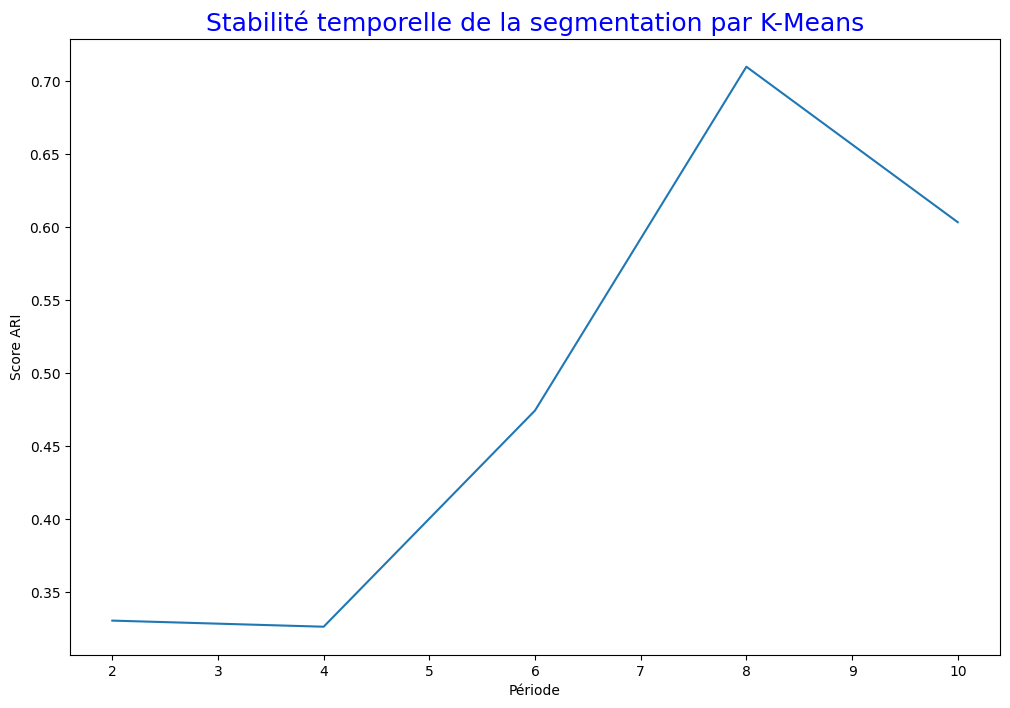

In [7]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Sur ce plot des scores ARI obtenus sur les itérations par période, on remarque un pic de performance à la période 8, suivi d'une forte baisse.</br>
Il faudra donc prévoir la maintenance du programme de segmentation tous les 8 mois dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner. Il sera donc nécessaire de redéfinir les segments clients à chaque maintenance.</br>
Cette approche permettra de capturer le moment optimal de performance du modèle, juste avant sa dégradation significative, assurant ainsi une segmentation client toujours pertinente et efficace.</br>